<a href="https://colab.research.google.com/github/jaloaiza/genaiassignments/blob/main/assignments/03/DP_LibraryAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Prereqs

In [2]:
!uv pip install openai-agents==0.4.2 gradio==5.49.1

Using Python 3.12.12 environment at: /usr
Resolved 77 packages in 781ms
Prepared 8 packages in 2.01s
Uninstalled 4 packages in 157ms
Installed 8 packages in 104ms
 + colorama==0.4.6
 - gradio==5.50.0
 + gradio==5.49.1
 - gradio-client==1.14.0
 + gradio-client==1.13.3
 + griffe==1.15.0
 + openai-agents==0.4.2
 - pydantic==2.12.3
 + pydantic==2.11.10
 - pydantic-core==2.41.4
 + pydantic-core==2.33.2
 + types-requests==2.32.4.20260107


# Set the OpenAI API Key Environment Variable

In [3]:
import sys
import os
from dotenv import load_dotenv

if 'google.colab' in sys.modules:
  from google.colab import userdata # type:ignore
  OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
  os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
else:
  load_dotenv()

# Vectore Store ID

In [4]:
VECTOR_STORE_ID = "vs_6974085c370481919f7e3b18183b74b7"

# Agents

In [5]:
from agents import Agent, Runner, FileSearchTool, WebSearchTool

## Cafe Agent

In [6]:
from agents import function_tool

@function_tool
def get_bytes_cafe_menu(date: str) -> any:
    return {
        f"{date}": {
            "daily byte": {
                "name": "Steak Quesadilla",
                "price": 12,
                "description": "Flank steak, mixed cheese in a flour tortilla served with air fried potatoes, sour cream and salsa",
            },
            "vegetarian": {
                "name": "Impossible Quesadilla",
                "price": 12,
                "description": "Impossible plant based product, mixed cheese in a flour tortilla served with air fried potatoes, sour cream and salsa",
            },
            "international": {
                "name": "Chicken Curry",
                "price": 12,
                "description": "Chicken thighs, onion, carrot, potato, curry sauce served over rice",
            },
        }
    }

In [7]:
cafe_agent = Agent(
    name="Cafe Agent",
    instructions="You help students locate and provide information about the Bytes Cafe.",
    tools=[
        get_bytes_cafe_menu,
    ],
)

## Building Agent

In [8]:
building_agent = Agent(
    name="Building Agent",
    instructions="You help students locate and provide information about buildings and rooms on campus. Be descriptive when giving locations.",
    tools=[
        FileSearchTool(
            max_num_results=3,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

## Course Agent

In [9]:
course_agent = Agent(
    name="Course Agent",
    instructions="You help students find out information about courses held at DigiPen.",
    tools=[
        FileSearchTool(
            max_num_results=5,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

## Handbook Agent

In [10]:
handbook_agent = Agent(
    name="Handbook Agent",
    instructions="You help students navigate the school handbook, providing information about campus policies and student conduct.",
    tools=[
        FileSearchTool(
            max_num_results=5,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        )
    ],
)

## DigiPen Library Agent

In [11]:
library_agent = Agent(
    name="DigiPen Library Agent",
    instructions=(
        "You help DigiPen Library (The Wing) patrons find resources, how to reserve study rooms, or how to check hours.\n"
        "Process:\n"
        "1) First, use FileSearchTool for internal/library documents and procedures.\n"
        "2) If FileSearchTool returns no results OR nothing clearly relevant, use WebSearchTool.\n"
        "3) If answers could change (hours/closures), prefer WebSearchTool and cite.\n"
        "Be transparent about which source you used."
    ),
    tools=[
        FileSearchTool(
            max_num_results=5,
            vector_store_ids=[VECTOR_STORE_ID],
            include_search_results=True,
        ),
        WebSearchTool(
            search_context_size = "low",
            user_location ={
                "type": "approximate",
                "country": "US",
                "region": "WA",
                "city": "Redmond"
            }
        )
    ],
)

## DigiPen Campus Agent

In [12]:
agent = Agent(
    name="DigiPen Campus Agent",
    instructions="You are a helpful campus agent that can plan and execute tasks for students at DigiPen Institute of Technology in Redmond, WA. Please be concise and accurate in handing off tasks to other agents as needed.",
    handoffs=[building_agent, course_agent, handbook_agent, cafe_agent, library_agent],
)

# Gradio Interface

## Chat function and display of tool calls

In [13]:
from gradio import ChatMessage

async def chat_with_agent(user_msg: str, history: list):
    messages = [{"role": msg["role"], "content": msg["content"]} for msg in history]
    messages.append({"role": "user", "content": user_msg})
    responses = []
    reply_created = False
    active_agent = None

    result = Runner.run_streamed(agent, messages)
    async for event in result.stream_events():
        if event.type == "raw_response_event":
            if event.data.type == "response.output_text.delta":
                if not reply_created:
                    responses.append(ChatMessage(role="assistant", content=""))
                    reply_created = True
                responses[-1].content += event.data.delta
        elif event.type == "agent_updated_stream_event":
            active_agent = event.new_agent.name
            responses.append(
                ChatMessage(
                    content=event.new_agent.name,
                    metadata={"title": "Agent Now Running", "id": active_agent},
                )
            )
        elif event.type == "run_item_stream_event":
            if event.item.type == "tool_call_item":
                if event.item.raw_item.type == "file_search_call":
                    responses.append(
                        ChatMessage(
                            content=f"Query used: {event.item.raw_item.queries}",
                            metadata={
                                "title": "File Search Completed",
                                "parent_id": active_agent,
                            },
                        )
                    )
                else:
                    tool_name = getattr(event.item.raw_item, "name", "unknown_tool")
                    tool_args = getattr(event.item.raw_item, "arguments", {})
                    responses.append(
                        ChatMessage(
                            content=f"Calling tool {tool_name} with arguments {tool_args}",
                            metadata={"title": "Tool Call", "parent_id": active_agent},
                        )
                    )
            if event.item.type == "tool_call_output_item":
                responses.append(
                    ChatMessage(
                        content=f"Tool output: '{event.item.raw_item['output']}'",
                        metadata={"title": "Tool Output", "parent_id": active_agent},
                    )
                )
            if event.item.type == "handoff_call_item":
                responses.append(
                    ChatMessage(
                        content=f"Name: {event.item.raw_item.name}",
                        metadata={
                            "title": "Handing Off Request",
                            "parent_id": active_agent,
                        },
                    )
                )
        yield responses

## Launch Gradio

In [ ]:
import gradio as gr

demo = gr.ChatInterface(
    chat_with_agent,
    title="DigiPen Campus Agent",
    theme=gr.themes.Soft(
        primary_hue="red", secondary_hue="slate", font=[gr.themes.GoogleFont("Inter")]
    ),
    examples=[
        "How do I reserve a private room at the Library?",
        "What's the policy for eating in auditoriums?",
        "What is the return policy for video games?",
        "What are the prerequisites for FLM201?"
    ],
    submit_btn=True,
    flagging_mode="manual",
    flagging_options=["Like", "Spam", "Inappropriate", "Other"],
    type="messages",
    save_history=False,
)

demo.launch(share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Analysis


## What Agent I Chose
I chose to make the DigiPen Library Agent. I am a student worker at the library, so getting the files needed for the vector store was a bit easier (they are all publicly accessibe files).

## How I Implemented Knowledge Retrieval
I first added a Vector Store off of OpenAI Platform with about 14 PDFs (including the given ones). Additionally, I added in a WebSearchTool, and gave the agent context of to only use the WebSearchTool if the FileSearchTool was invalid.

## Traces


The traces show me the longer execution times, and the handoffs that happened. Aka the Agent Workflow.


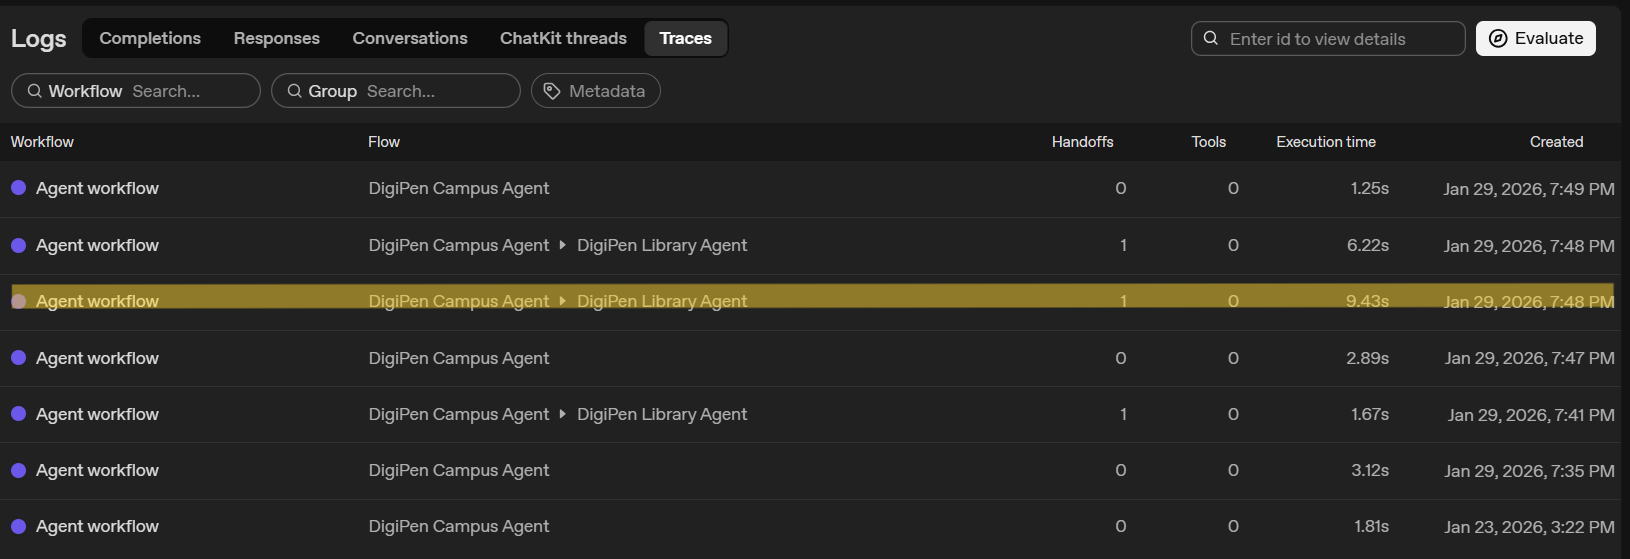

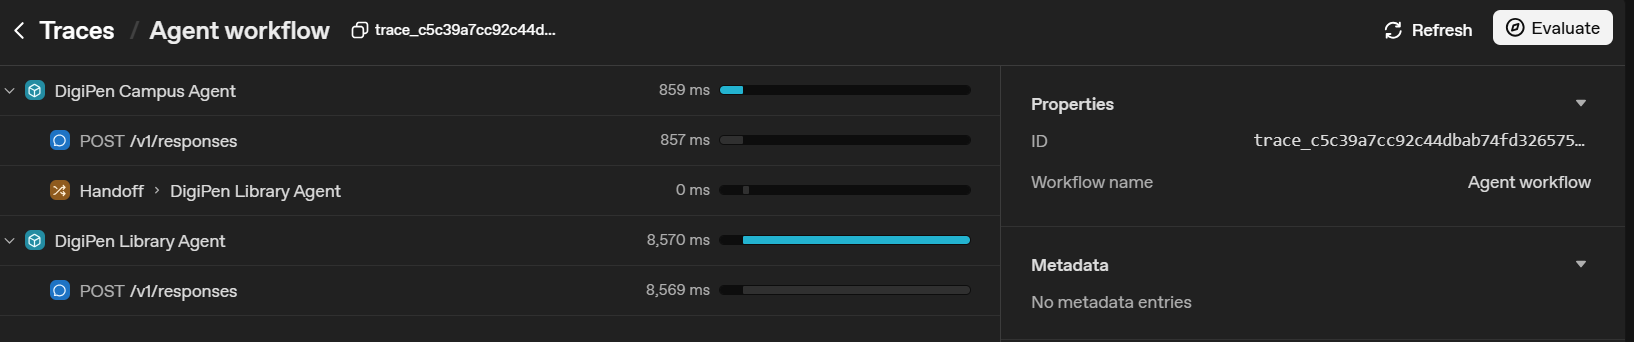

# Queries

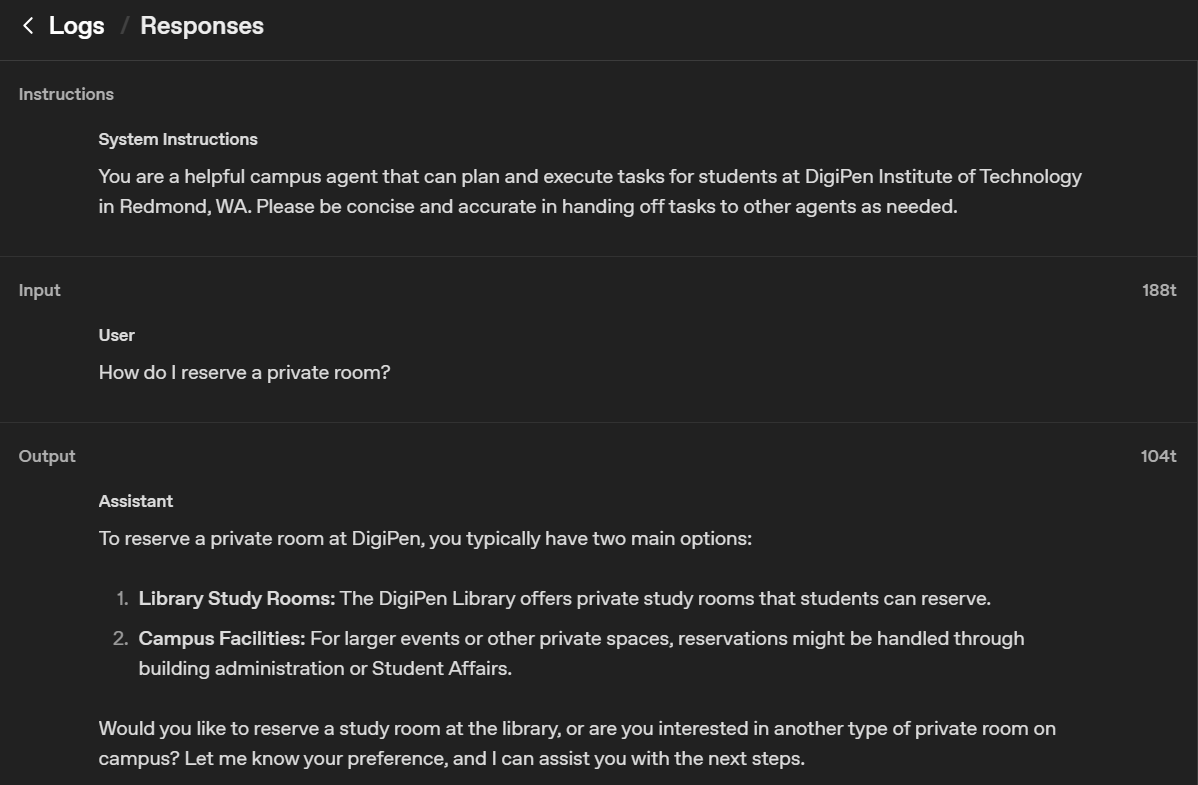

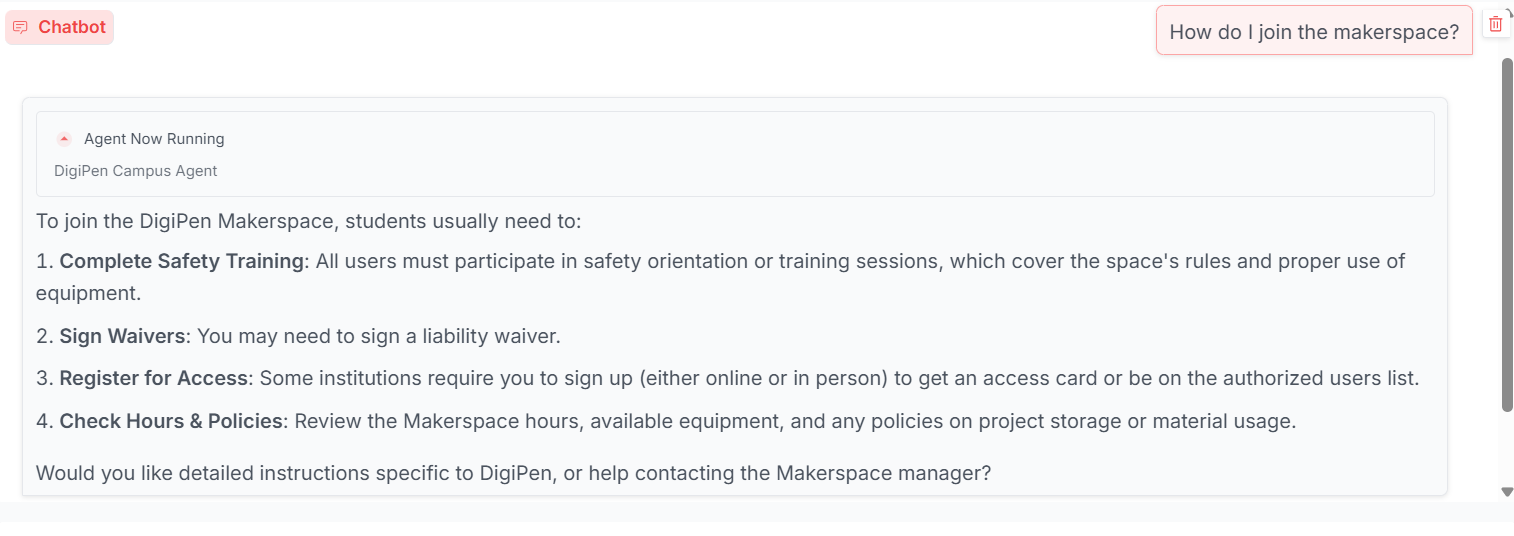

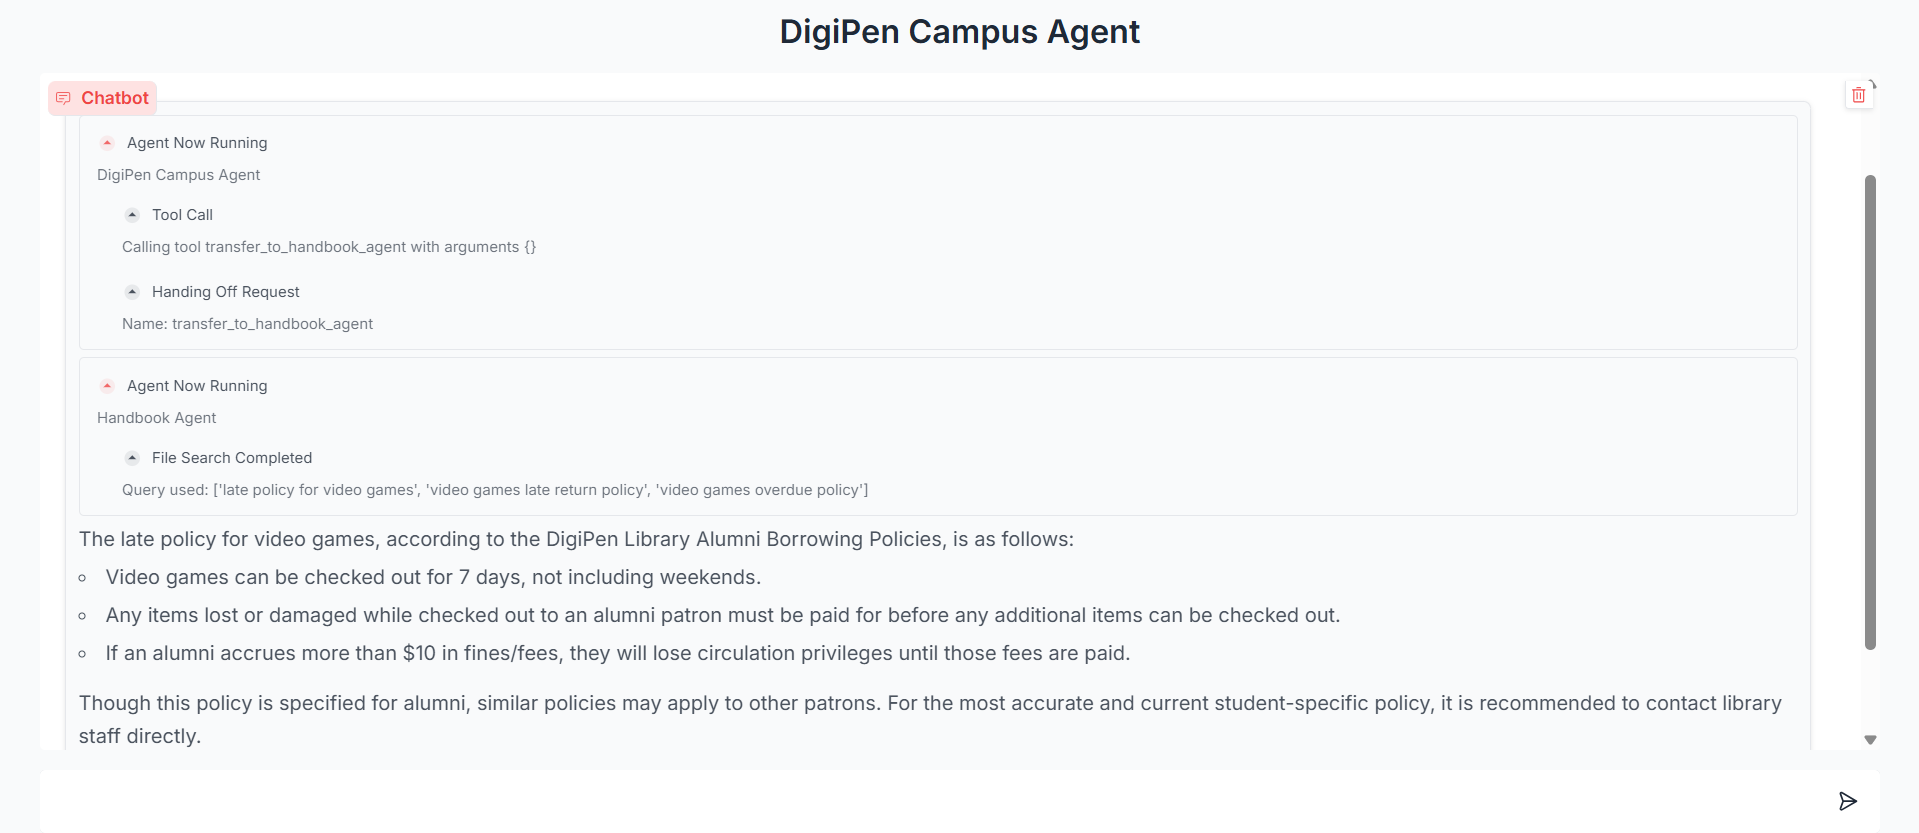